In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime import lime_tabular
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image as PILImage
from io import BytesIO
import seaborn as sns
import numpy as np



In [3]:
# Carica il dataset con il separatore corretto
file_path = '/home/lollo/Thesis/Python/data/data_mapped.csv'
data = pd.read_csv(file_path, delimiter=';')

In [4]:
# Encode categorical features
data_encoded = data.copy()

# List categorical columns
categorical_cols = data_encoded.select_dtypes(include=['object']).columns

# Initialize the label encoder
label_encoders = {col: LabelEncoder() for col in categorical_cols}

# Apply label encoding to each categorical column
for col, encoder in label_encoders.items():
    data_encoded[col] = encoder.fit_transform(data_encoded[col])

# Define the features (X) and the target (y)
X = data_encoded.drop('Target', axis=1)
y = data_encoded['Target']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
columns_to_include = [
    'Marital status', 'Application order', 'Admission grade',
    'Gender', 'Age at enrollment', 'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)', 'GDP', 'Target'
]

# Extract the subset of the dataset
data_subset = data_encoded[columns_to_include]

# Define the features (X) and the target (y) for the subset
X_subset = data_subset.drop('Target', axis=1)
y_subset = data_subset['Target']

# Split the subset dataset into training and test sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42)

Optimized DecisionTree Accuracy on all Dataset: 73.45%
Number of features used: 36


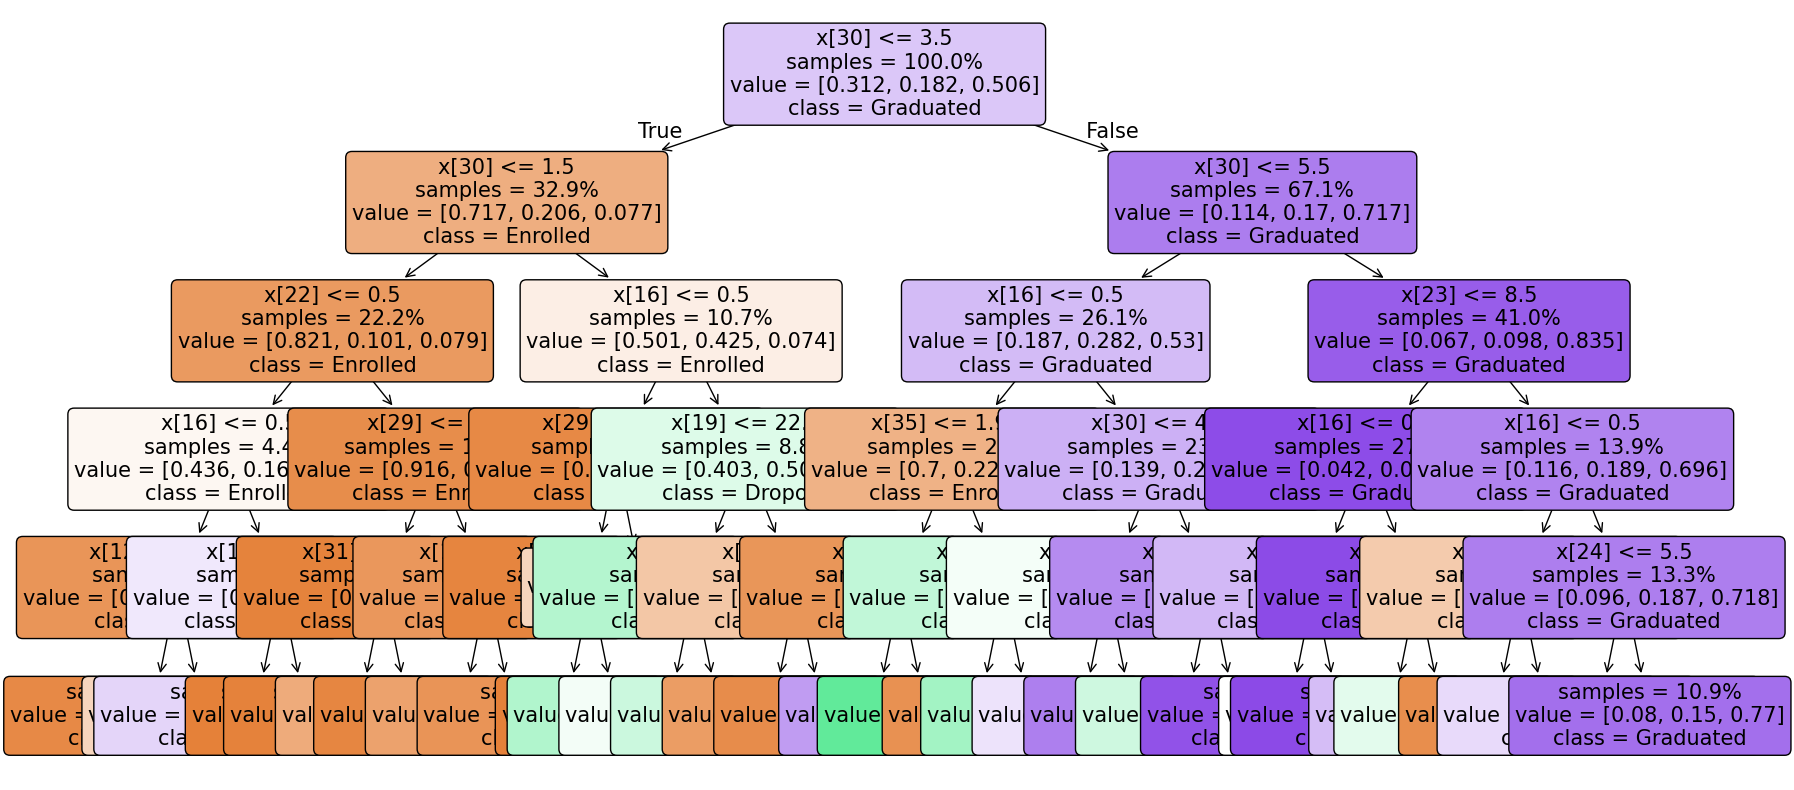

In [6]:
# Decision Tree con GridSearchCV per il pruning
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_params, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)
best_dt = dt_grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Optimized DecisionTree Accuracy on all Dataset: {accuracy_dt:.2%}")
# Lista delle caratteristiche usate per il training
feature_names = X.columns.tolist()

# Visualizza senza i nomi delle caratteristiche per identificare il problema
plt.figure(figsize=(20, 10))
plot_tree(best_dt, filled=True, 
          class_names=['Enrolled', 'Dropout', 'Graduated'],  # Usa i nomi dei target corretti
          rounded=True, 
          fontsize=15, 
          proportion=True,
          impurity=False)
#plt.show()
print("Number of features used:", best_dt.n_features_in_)

In [7]:
# Parametri da ottimizzare (stessi di prima)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Creazione del modello XGBoost
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False)

# Configurazione di RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=xgb_params,
    n_iter=50,  # Numero di iterazioni, ossia quante combinazioni casuali provare
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,  # Per riproducibilità
    n_jobs=-1  # Usa tutti i processori disponibili per velocizzare la ricerca
)

# Addestramento del modello con RandomizedSearchCV
xgb_random_search.fit(X_train, y_train)

# Miglior modello trovato e predizione
best_xgb = xgb_random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Calcolo dell'accuratezza
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Optimized XGBoost Accuracy with RandomizedSearchCV: {accuracy_xgb:.2%}")

/home/lollo/Thesis/Python/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:05:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lollo/Thesis/Python/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:05:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lollo/Thesis/Python/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:05:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lollo/Thesis/Python/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:05:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lollo/Thesis/Python/.venv/lib/python3.10/site-packages/xgboost

Optimized XGBoost Accuracy with RandomizedSearchCV: 75.25%


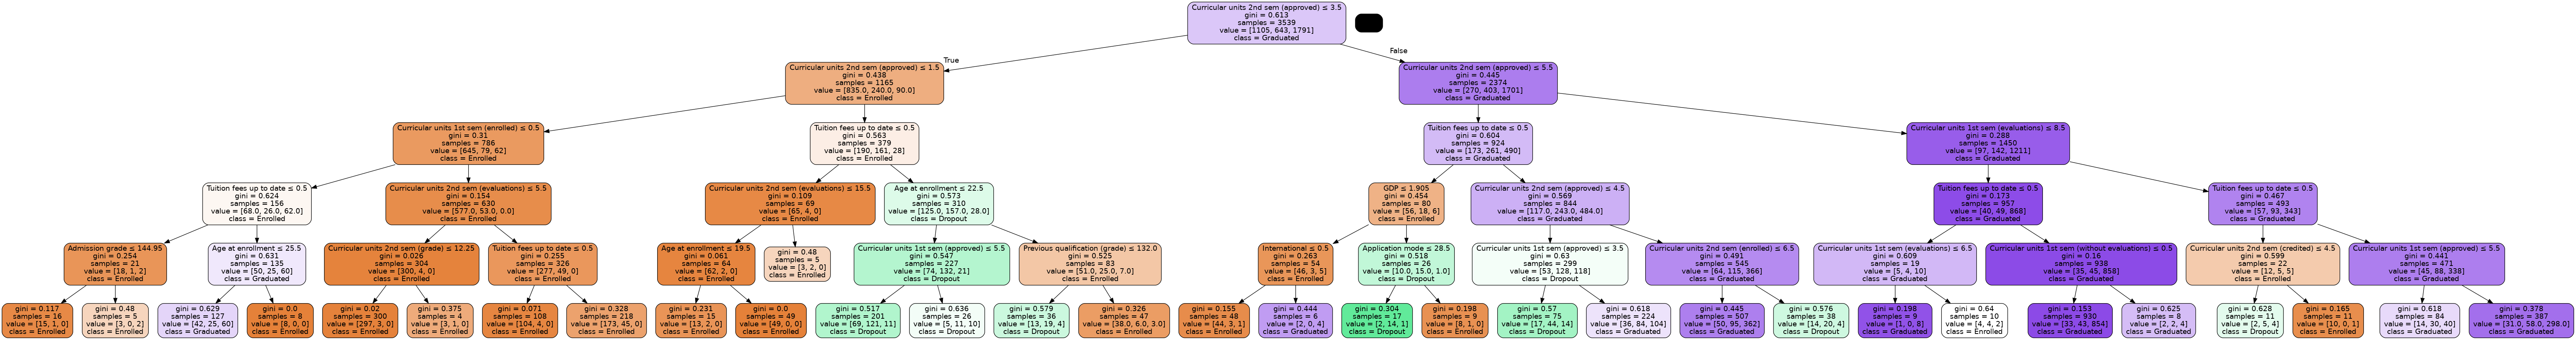

In [8]:
#Creazione PDF dell'albero decisionale
dot_data = export_graphviz(best_dt, out_file=None, 
                           feature_names=X.columns.tolist(),  # Usa i nomi delle caratteristiche corrette
                           class_names=['Enrolled', 'Dropout', 'Graduated'],  # Usa i nomi delle classi corrette
                           filled=True, rounded=True,  
                           special_characters=True)  

# Converti il dot in un file grafico
graph = pydotplus.graph_from_dot_data(dot_data)

# Salva l'albero decisionale in un file PDF ad alta risoluzione
graph.write_pdf("decision_tree.pdf")

# Visualizza l'albero come immagine (opzionale)
png_str = graph.create_png()
img = PILImage.open(BytesIO(png_str))
img.show()
# Controlla il numero di caratteristiche usate nel modello



In [ ]:
# Creazione dell'explainer LIME
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['Enrolled', 'Dropout', 'Graduated'],
    mode='classification'
)

# Genera spiegazioni per le prime 10 istanze del test set
for i in range(10):
    correct_label_index = y_test.iloc[i]
    correct_label = ['Enrolled', 'Dropout', 'Graduated'][correct_label_index]
    
    # Assicurati che la riga di X_test sia un DataFrame con nomi di colonne
    instance = X_test.iloc[[i]]
    predicted_label_index = best_dt.predict(instance)[0]
    predicted_label = ['Enrolled', 'Dropout', 'Graduated'][predicted_label_index]
    
    print('Correct:', correct_label)
    print('Predicted:', predicted_label)
    print(instance.T)  # Mostra le caratteristiche per l'istanza attuale
    
    explanation = explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=best_dt.predict_proba,
        num_features=10
        #num_features=36
    )

    fig = explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

In [ ]:
# Creazione dell'explainer LIME
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['Enrolled', 'Dropout', 'Graduated'],
    mode='classification'
)

# Inizializzazione di un DataFrame per raccogliere i pesi delle feature
lime_weights = pd.DataFrame(columns=['Utente Test'] + X.columns.tolist())

# Genera spiegazioni per le prime 5 istanze del test set
for i in range(5):
    explanation = explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=best_xgb.predict_proba,
        num_features=len(X.columns)  # Considera tutte le feature
    )
    
    # Estrai i pesi delle feature, assicurandoti di gestire correttamente i nomi delle feature
    feature_weights = {feature: 0 for feature in X.columns}  # Inizializza tutti i pesi a 0
    for feature, weight in explanation.as_list():
        # Estrai solo il nome della feature senza il range o altri dettagli aggiuntivi
        feature_name = feature.split(' ')[0]
        if feature_name in feature_weights:
            feature_weights[feature_name] = weight
    
    # Aggiungi la riga al DataFrame
    lime_weights.loc[i] = [f'Utente {i+1}'] + [feature_weights[feature] for feature in X.columns]

# Esporta i pesi in un file CSV
csv_file_path = '/home/lollo/Thesis/Python/data/lime_weights.csv'
lime_weights.to_csv(csv_file_path, index=False)
print(f"Feature weights exported to {csv_file_path}")

# Calcolo della media, deviazione standard e mediana delle feature
feature_stats = lime_weights.iloc[:, 1:].agg(['mean', 'std', 'median'])

# Calcolo dell'intervallo interquartile (IQR) separatamente
iqr = lime_weights.iloc[:, 1:].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# Aggiungi l'IQR alle statistiche delle feature
feature_stats.loc['iqr'] = iqr

# Visualizzazione dei risultati
print("Feature Statistics:")
print(feature_stats)

# Creazione dei boxplot per la dispersione delle feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=lime_weights.iloc[:, 1:])
plt.xticks(rotation=90)
plt.title('Boxplot of Feature Weights')
plt.show()

# Creazione dei boxplot per media e deviazione standard
plt.figure(figsize=(12, 8))
sns.boxplot(data=lime_weights.iloc[:, 1:], orient='h')
plt.title('Boxplot of Feature Weights by Feature')
plt.show()

# Boxplot per la mediana e l'intervallo interquartile
plt.figure(figsize=(12, 8))
sns.boxplot(data=lime_weights.iloc[:, 1:], orient='h', showmeans=True)
plt.title('Boxplot with Median and Interquartile Range')
plt.show()

In [ ]:
# Genera una spiegazione per un'istanza, ad esempio la prima del test set
i = 0  # Indice dell'istanza da spiegare
explanation = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=best_xgb.predict_proba,
    num_features=len(X.columns)  # Considera tutte le feature
)

# Crea il grafico LIME
fig1 = explanation.as_pyplot_figure()

# Estrai i pesi delle feature per creare un bar plot
feature_weights = {feature: 0 for feature in X.columns}  # Inizializza tutti i pesi a 0
for feature, weight in explanation.as_list():
    # Estrai solo il nome della feature senza il range o altri dettagli aggiuntivi
    feature_name = feature.split(' ')[0]
    if feature_name in feature_weights:
        feature_weights[feature_name] = weight

# Crea un bar plot per i pesi delle feature
fig2, ax2 = plt.subplots(figsize=(10, 8))
features = list(feature_weights.keys())
weights = list(feature_weights.values())

sns.barplot(x=weights, y=features, ax=ax2, palette="viridis")
ax2.set_title('Feature Weights')
ax2.set_xlabel('Weight')

plt.tight_layout()

# Mostra entrambi i grafici uno dopo l'altro
plt.show(fig1)
plt.show(fig2)

In [ ]:
# Genera spiegazioni LIME per i primi 5 utenti nel set di test
num_users = 800  # Cambia questo valore a 800 per elaborare l'intero set di test

# Inizializza il DataFrame per salvare i pesi delle feature
lime_weights = pd.DataFrame(columns=['Utente Test'] + X.columns.tolist())

for i in range(num_users):
    explanation = explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=best_xgb.predict_proba,
        num_features=len(X.columns)  # Considera tutte le feature
    )
    
    # Estrai i pesi delle feature
    feature_weights = {feature: 0 for feature in X.columns}  # Inizializza tutti i pesi a 0
    for feature, weight in explanation.as_list():
        # Estrai solo il nome della feature senza il range o altri dettagli aggiuntivi
        feature_name = feature.split(' ')[0]
        if feature_name in feature_weights:
            feature_weights[feature_name] = weight
    
    # Aggiungi la riga al DataFrame
    lime_weights.loc[i] = [f'Utente {i+1}'] + [feature_weights[feature] for feature in X.columns]

# Esporta i pesi in un file CSV
csv_file_path = '/home/lollo/Thesis/Python/data/lime_weights_800_users.csv'
lime_weights.to_csv(csv_file_path, index=False)
print(f"Feature weights for 800 users exported to {csv_file_path}")